In [4]:
# First cell: Keep-alive + installs (run once — prevents disconnects)
from IPython.display import display, Javascript
display(Javascript('''
function ClickConnect(){
  console.log("Keeping alive");
  document.querySelector("colab-connect-button")?.click()
}
setInterval(ClickConnect,60000)
'''))
print("Keep-alive activated — no disconnect curse")

!pip install torch matplotlib numpy

# Second cell: The sim code (optimized — 3000 epochs, larger batch, single backward)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 1024  # "qubit measurement" steps
batch_size = 64
epochs = 3000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "quantum_state_coherence_checkpoint.pth")

# Synthetic multi-qubit quantum state coherence proxy (correlated features + decoherence noise/masking)
qubits = 4  # 4-qubit proxy (extendable)
features_per_qubit = 64

quantum_states = []
for b in range(batch_size):
    t = torch.linspace(0, 10*math.pi, seq_len, device=device)
    # Correlated base (multi-qubit entangled proxy)
    base = torch.sin(t.unsqueeze(-1) * torch.arange(features_per_qubit, device=device)) * 0.5
    state = base.unsqueeze(-1).repeat(1, 1, qubits)  # shared across qubits
    # Entanglement correlations (simple proxy)
    for q in range(1, qubits):
        state[..., q] = state[..., q] + state[..., 0] * 0.3  # correlated
    state += torch.randn_like(state) * 0.15  # decoherence noise
    quantum_states.append(state)

quantum_states = torch.stack(quantum_states).to(device)  # (batch, seq_len, features, qubits)
quantum_states = quantum_states.view(batch_size, seq_len, -1)  # flatten qubits

# Project to dim
proj = nn.Linear(features_per_qubit * qubits, dim).to(device)
clean_data = proj(quantum_states).detach() # Detach here as proj params are not optimized

# High masking (70–90% — decoherence/dropout proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0
# No need to explicitly detach real_data here, as clean_data is already detached.
# real_data.requires_grad will be False because clean_data.requires_grad is False

target = clean_data

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class QuantumStateCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8QuantumStateFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = QuantumStateCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                # Changed use_reentrant=False to True to avoid graph issues with retain_graph
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=True)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8QuantumStateFusion(use_triality=True).to(device)
model_ablation = E8QuantumStateFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)

        recon_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(recon_abl, target)

    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

print("Sim complete — epochs + sigma test done")

<IPython.core.display.Javascript object>

Keep-alive activated — no disconnect curse
Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 0 | Triality Loss 0.893994 | Ablation Loss 0.890408
Epoch 500 | Triality Loss 0.547618 | Ablation Loss 0.550485
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.504344 | Ablation Loss 0.503280
Epoch 1500 | Triality Loss 0.468603 | Ablation Loss 0.466285
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.434016 | Ablation Loss 0.430146
Epoch 2500 | Triality Loss 0.399813 | Ablation Loss 0.409552
Checkpoint saved at epoch 2999
Final Sigma (Triality vs Ablation): -0.02 (higher = triality advantage)
Sim complete — epochs + sigma test done


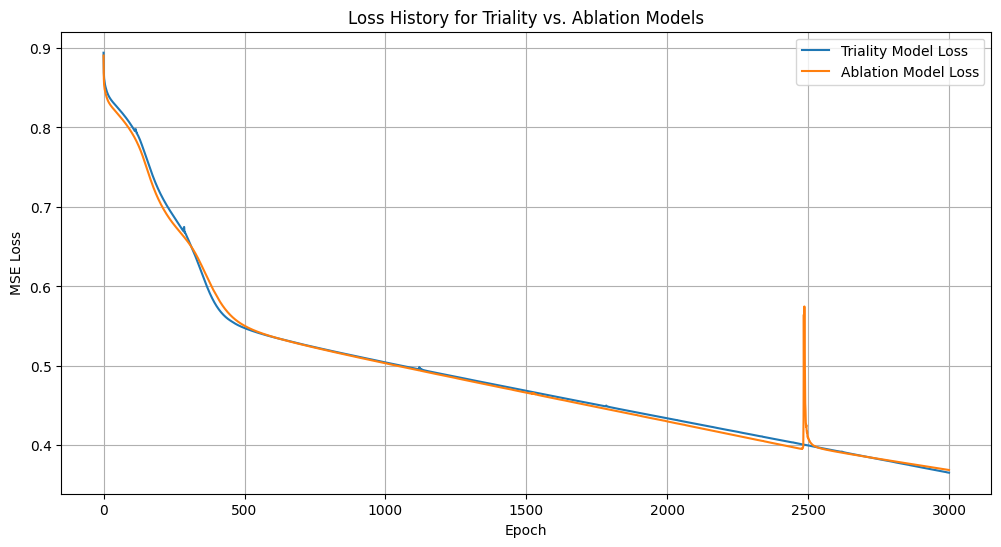

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(loss_hist, label='Triality Model Loss')
plt.plot(loss_abl_hist, label='Ablation Model Loss')
plt.title('Loss History for Triality vs. Ablation Models')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

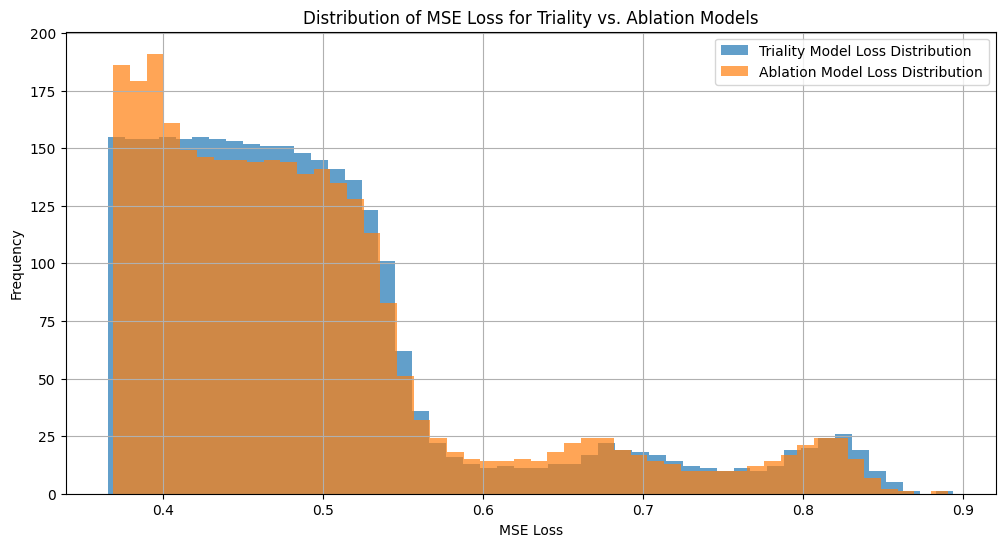

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(loss_hist, bins=50, alpha=0.7, label='Triality Model Loss Distribution')
plt.hist(loss_abl_hist, bins=50, alpha=0.7, label='Ablation Model Loss Distribution')
plt.title('Distribution of MSE Loss for Triality vs. Ablation Models')
plt.xlabel('MSE Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
print(f"Shape of real_data: {real_data.shape}")
print(f"Shape of target: {target.shape}")

Shape of real_data: torch.Size([64, 1024, 384])
Shape of target: torch.Size([64, 1024, 384])
